# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
### Import Libraries

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Step 1: Camera Calibration

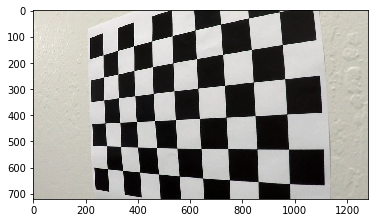

In [2]:
image=mpimg.imread('./camera_cal/calibration4.jpg')
plt.imshow(image)

In [3]:
# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

Images_with_Corners=[]

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        Images_with_Corners.append(img)
        cv2.imshow('img',img)
        cv2.waitKey(500)        

cv2.destroyAllWindows()

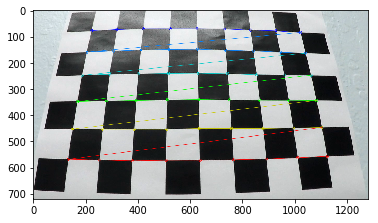

In [4]:
plt.imshow(Images_with_Corners[12])

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Image Read

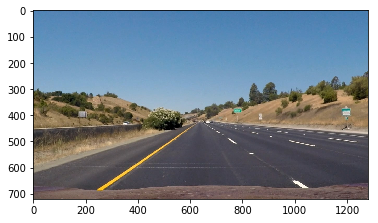

In [6]:
fname = './test_images/straight_lines1.jpg'
test_image = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB)

plt.imshow(test_image)

## Step 2: Distortion Correction

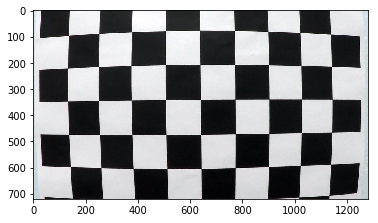

In [7]:
chess_image=cv2.imread(images[0])
plt.imshow(chess_image)

In [8]:
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

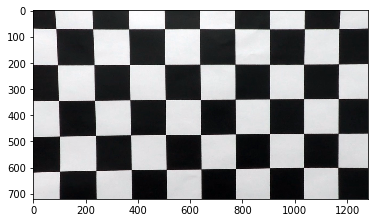

In [9]:
plt.imshow(undistort(chess_image))

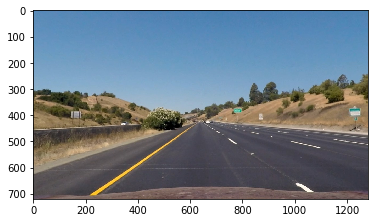

In [10]:
undistorted_image = undistort(test_image)
plt.imshow(undistorted_image)

## Step 3: Gradient and Color Transform

In [11]:
def hls_transform(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat = hls[:,:,2]
    binary = np.zeros_like(sat)
    binary[(sat > thresh[0]) & (sat <= thresh[1])] = 1
    return binary

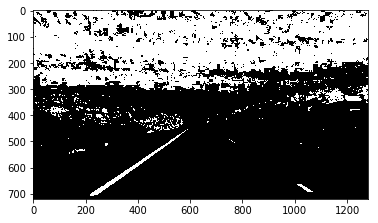

In [12]:
hls = hls_transform(undistorted_image, (100,255))
plt.imshow(hls,cmap='gray')

In [13]:
def abs_grad(img, sobel_kernel, thresh, orient):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def mag_grad(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary = np.zeros_like(gradmag)
    binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary

def dir_grad(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    graddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary = np.zeros_like(graddir)
    binary[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return binary

In [14]:
def combined_gradient(img, ksize):
    gradx = abs_grad(img, sobel_kernel=ksize, thresh=(100, 255), orient='x')
    grady = abs_grad(img, sobel_kernel=ksize, thresh=(100, 255), orient='y')
    mag_binary = mag_grad(img, sobel_kernel=ksize, thresh=(100, 255))
    dir_binary = dir_grad(img, sobel_kernel=ksize, thresh=(np.pi/4, np.pi/2))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

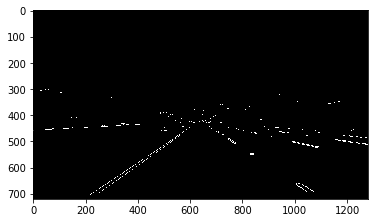

In [15]:
grad = combined_gradient(undistorted_image, 3)
plt.imshow(grad, cmap='gray')

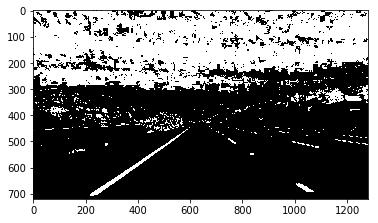

In [16]:
mixed = np.zeros_like(grad)
mixed[(grad == 1) | (hls == 1)] = 1

plt.imshow(mixed, cmap='gray')

## Step 4: Perspective Transform

In [17]:
def pers_trans(img, src, dst):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

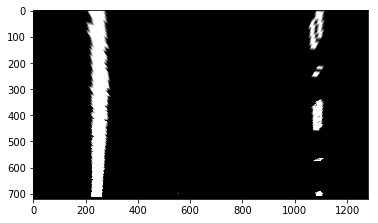

In [18]:
img_size = (undistorted_image.shape[1], undistorted_image.shape[0])

src = np.float32([[np.int(img_size[0]*0.435), np.int(img_size[1]*0.65)],
                  [np.int(img_size[0]*0.565), np.int(img_size[1]*0.65)],
                  [np.int(img_size[0]*0.9), img_size[1]],
                  [np.int(img_size[0]*0.1), img_size[1]]])
offset = 150

dst = np.float32([[offset, 0], 
                  [img_size[0]-offset, offset], 
                  [img_size[0]-offset, img_size[1]], 
                  [offset, img_size[1]]])

warped = pers_trans(mixed,src,dst)

plt.imshow(warped, cmap = 'gray')

## Step 5: Lane Lines Detection

In [19]:
def histo(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

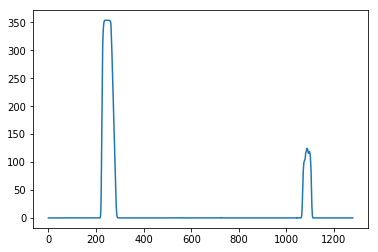

In [20]:
histogram = histo(warped)
plt.plot(histogram)

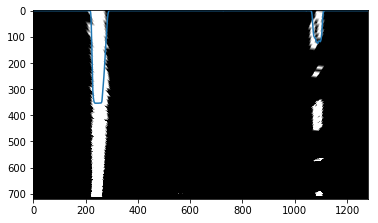

In [21]:
plt.imshow(warped, cmap='gray')
plt.plot(histogram)

## Step 6: Polynomial Fit

(720, 0)

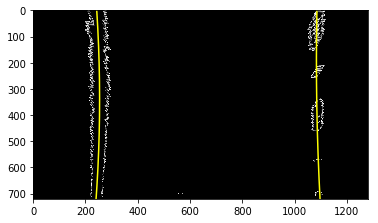

In [22]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

plt.imshow(out_img)
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 10) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 10) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


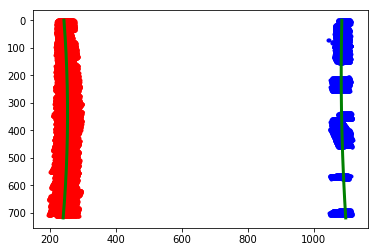

In [23]:

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

mark_size = 3
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
#plt.xlim(0, 1280)
#plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

(1, 1440, 2)


(720, 0)

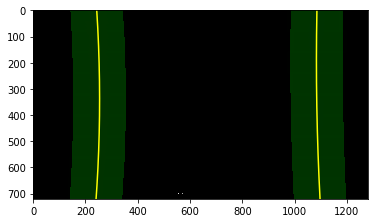

In [24]:
window_img = np.zeros_like(out_img)
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))
print(left_line_pts.shape)
# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Step 7: Lane Curvature

In [25]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

5392.52270615 10077.3617714


In [26]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

1970.35412771 m 4205.557243 m


## Step 8: Lane Boundaries Overlay on Original Image

In [41]:
fill_lane=np.zeros_like(warped)
#overlay = cv2.addWeighted(test_image, 1, unwarp, 0.3, 0)
pts=[]
pts=np.concatenate([leftx,lefty,rightx,righty])
print(type(pts))
cv2.fillPoly(fill_lane, np.int_([pts]), (0,255, 0))
unwarp = pers_trans(fill_lane, dst, src)
plt.imshow(unwarp, cmap = 'Greys_r')

<class 'numpy.ndarray'>


error: ..\..\..\modules\imgproc\src\drawing.cpp:2276: error: (-215) p.checkVector(2, CV_32S) >= 0 in function cv::fillPoly


In [28]:
# Draw the lane onto the warped blank image
line_pts=np.hstack((left_line_pts,right_line_pts))

cv2.fillPoly(window_img, np.int32([line_pts]), (0,255, 0))
result = cv2.addWeighted(warped, 1, window_img, 0.3, 0)

plt.imshow(result, cmap = 'Greys_r')

error: ..\..\..\modules\core\src\arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function cv::arithm_op
